### Импорты

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

### Загрузка данных и препроцессинг

In [2]:
data = pd.read_pickle("../data/task_3/train.pickle")
data_array = []
for i in range(len(data['labels'])):
    data_array.append(np.hstack((data['labels'][i], data['coords'][i].reshape(-1), data['features'][i].reshape(-1))))
data_array=np.asarray(data_array)

In [3]:
labels = pd.read_csv("../data/task_3/label_names.csv", index_col="ClassId")
labels = labels.to_dict()["SignName"]

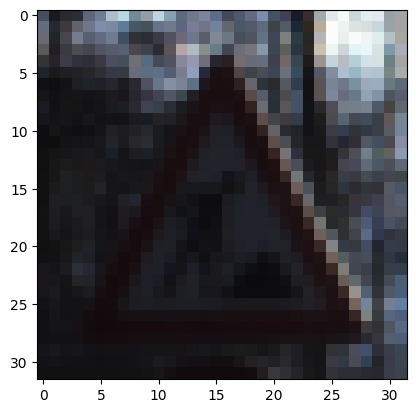

In [4]:
plt.imshow(data['features'][-1])
None

Будем также использовать признак "координаты", коль есть такая возможность  
Все пиксели просто растянем в вектор

In [5]:
columns = ["label", *[f"coord_{i}" for i in range(4)], *[f"point_{i}" for i in range(32*32*3)]]
df = pd.DataFrame(columns=columns, data=data_array)
df.head()

,label,coord_0,coord_1,coord_2,coord_3,point_0,point_1,point_2,point_3,point_4,...,point_3062,point_3063,point_3064,point_3065,point_3066,point_3067,point_3068,point_3069,point_3070,point_3071
0,41,6,5,21,20,28,25,24,27,24,...,22,27,24,22,27,23,21,26,22,20
1,41,6,6,22,22,28,24,24,26,23,...,22,27,23,22,27,24,23,29,26,25
2,41,5,6,22,23,29,25,25,29,26,...,22,29,25,23,28,24,22,30,26,24
3,41,5,6,22,23,31,28,26,29,26,...,22,28,23,22,27,23,22,27,23,21
4,41,5,6,23,23,33,27,25,31,25,...,21,25,22,20,26,22,19,27,22,19


In [6]:
X = df.drop(["label"], axis=1)
y = df.label

Заметим, что классы не сбалансированы

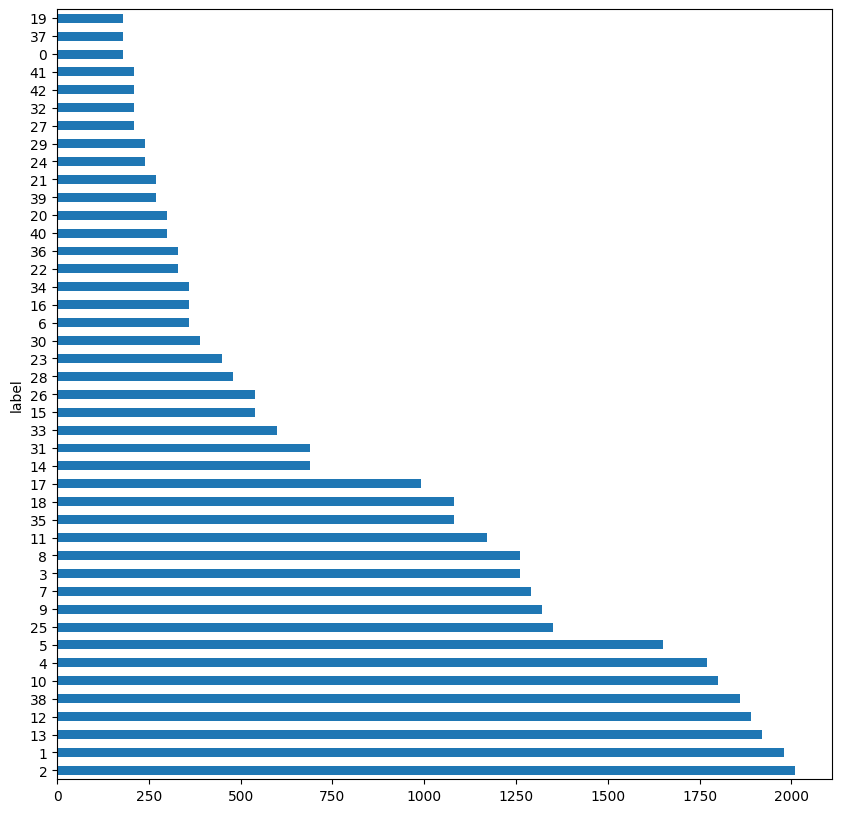

In [7]:
y.value_counts().plot(kind='barh', figsize=(10, 10))
None

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Выводить будем метрики accuracy, precision, recall и f1-score, а также матрицу из TP - TN - FP - FN  для каждого знака  
Нас интересует метрика F1-score:  
- Для accuracy классы слишком дисбалансированы 
- Выбирать что-то из precision и recall не имеет смысла, у нас нет задачи именно правильно детектировать все какие-то конкретные знаки или около того

In [9]:
def print_score(y_test, y_pred):
    print(f"accuracy_score:\t\t{accuracy_score(y_test, y_pred)}")
    print(f"precision_score:\t{precision_score(y_test, y_pred, average='macro')}")
    print(f"recall_score:\t\t{recall_score(y_test, y_pred, average='macro')}")
    print(f"f1_score:\t\t{f1_score(y_test, y_pred, average='macro')}")

    cm = confusion_matrix(y_test, y_pred)
    cm = cm / cm.sum(axis=1).reshape(-1, 1)
    cm = cm.round(3)

    _, ax = plt.subplots(figsize=(32, 32))
    sns.heatmap(cm, annot=True, ax=ax, cmap="binary", cbar=False)

## Task 1 (easy)

In [10]:
model_logreg = LogisticRegression(max_iter=200, random_state=42)
model_logreg.fit(X_train, y_train)
y_pred_logreg = model_logreg.predict(X_test)

/home/mitchell/different/hse-ml-course/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy_score:		0.9498563218390804
precision_score:	0.9523257545844247
recall_score:		0.9403339559539157
f1_score:		0.9458530559050184


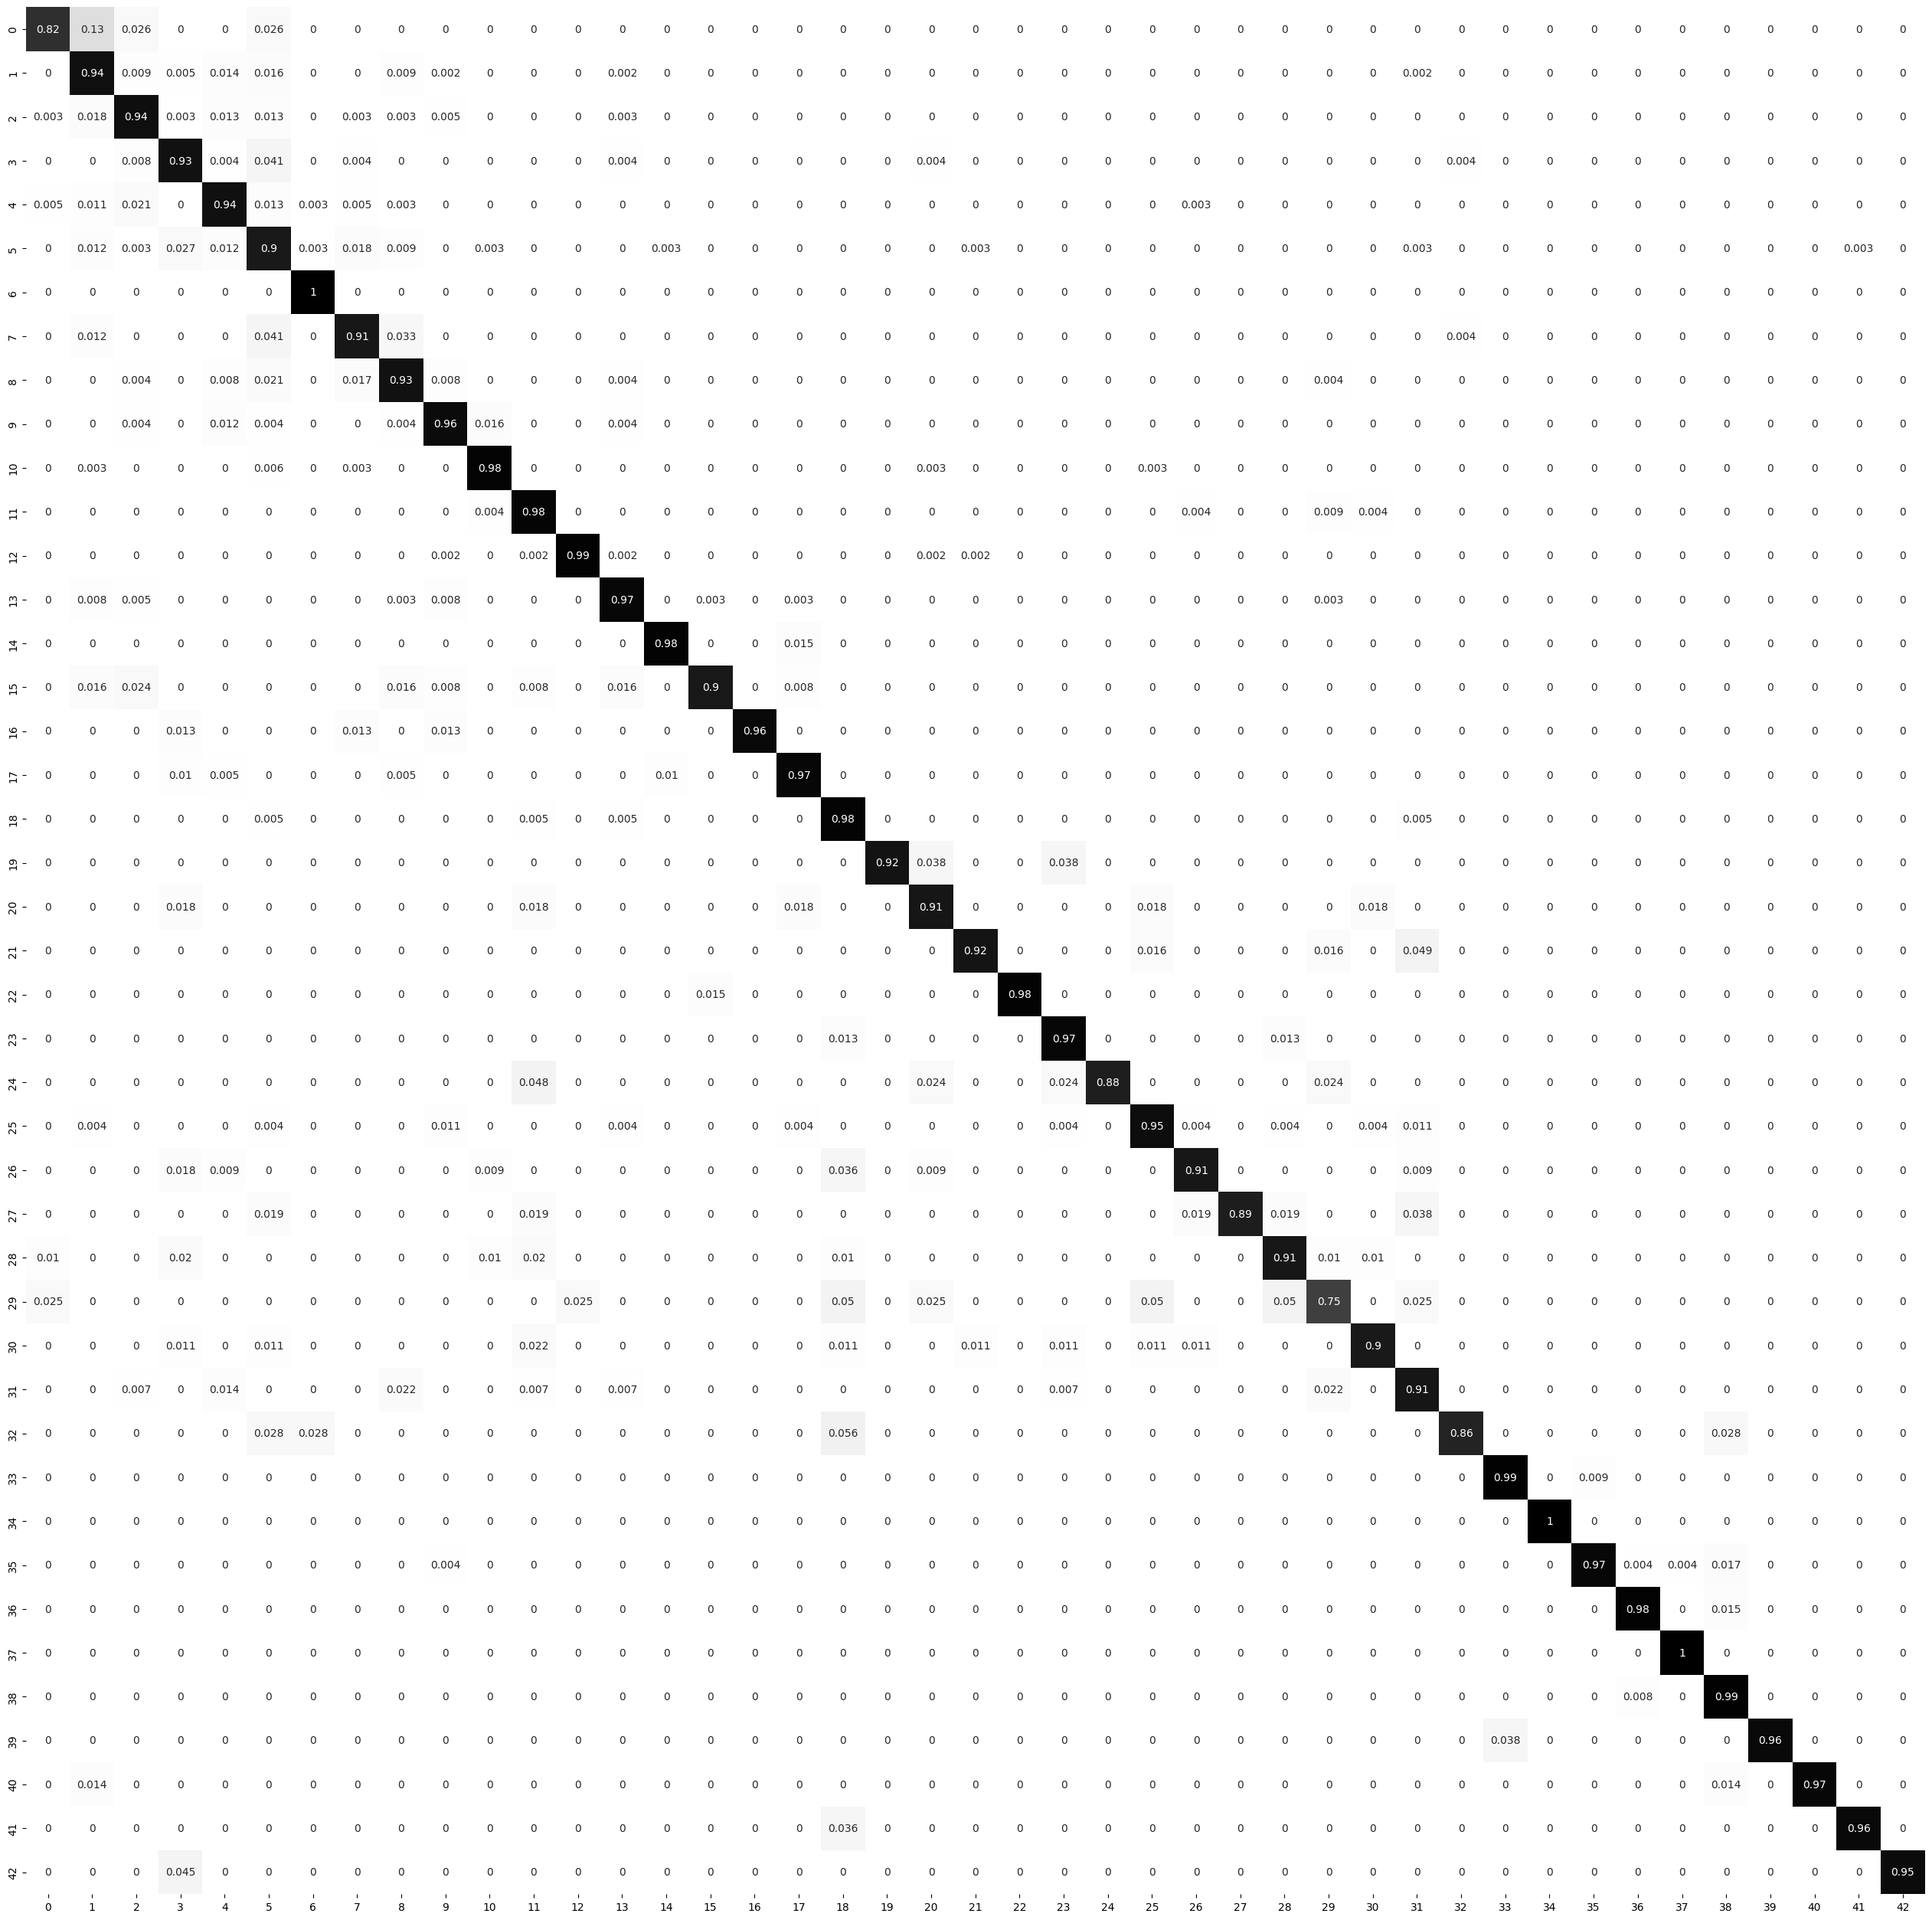

In [11]:
print_score(y_test, y_pred_logreg)

In [12]:
labels[29], labels[0]

('Bicycles crossing', 'Speed limit (20km/h)')

Логистическая регрессия показала очень хороший скор, хуже всего распознаются знаки "Bicycles crossing" и "Speed limit (20km/h)"  
Причем интересно отметить, что "Speed limit (20km/h)" путается с похожими для нее знаками Speed limit (X km/h), а вот "Bicycles crossing" просто плохо распознается

## Task 2 (medium)

### KNN

In [13]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

accuracy_score:		0.8722701149425287
precision_score:	0.8911093131001769
recall_score:		0.8681844258878876
f1_score:		0.877136185680888


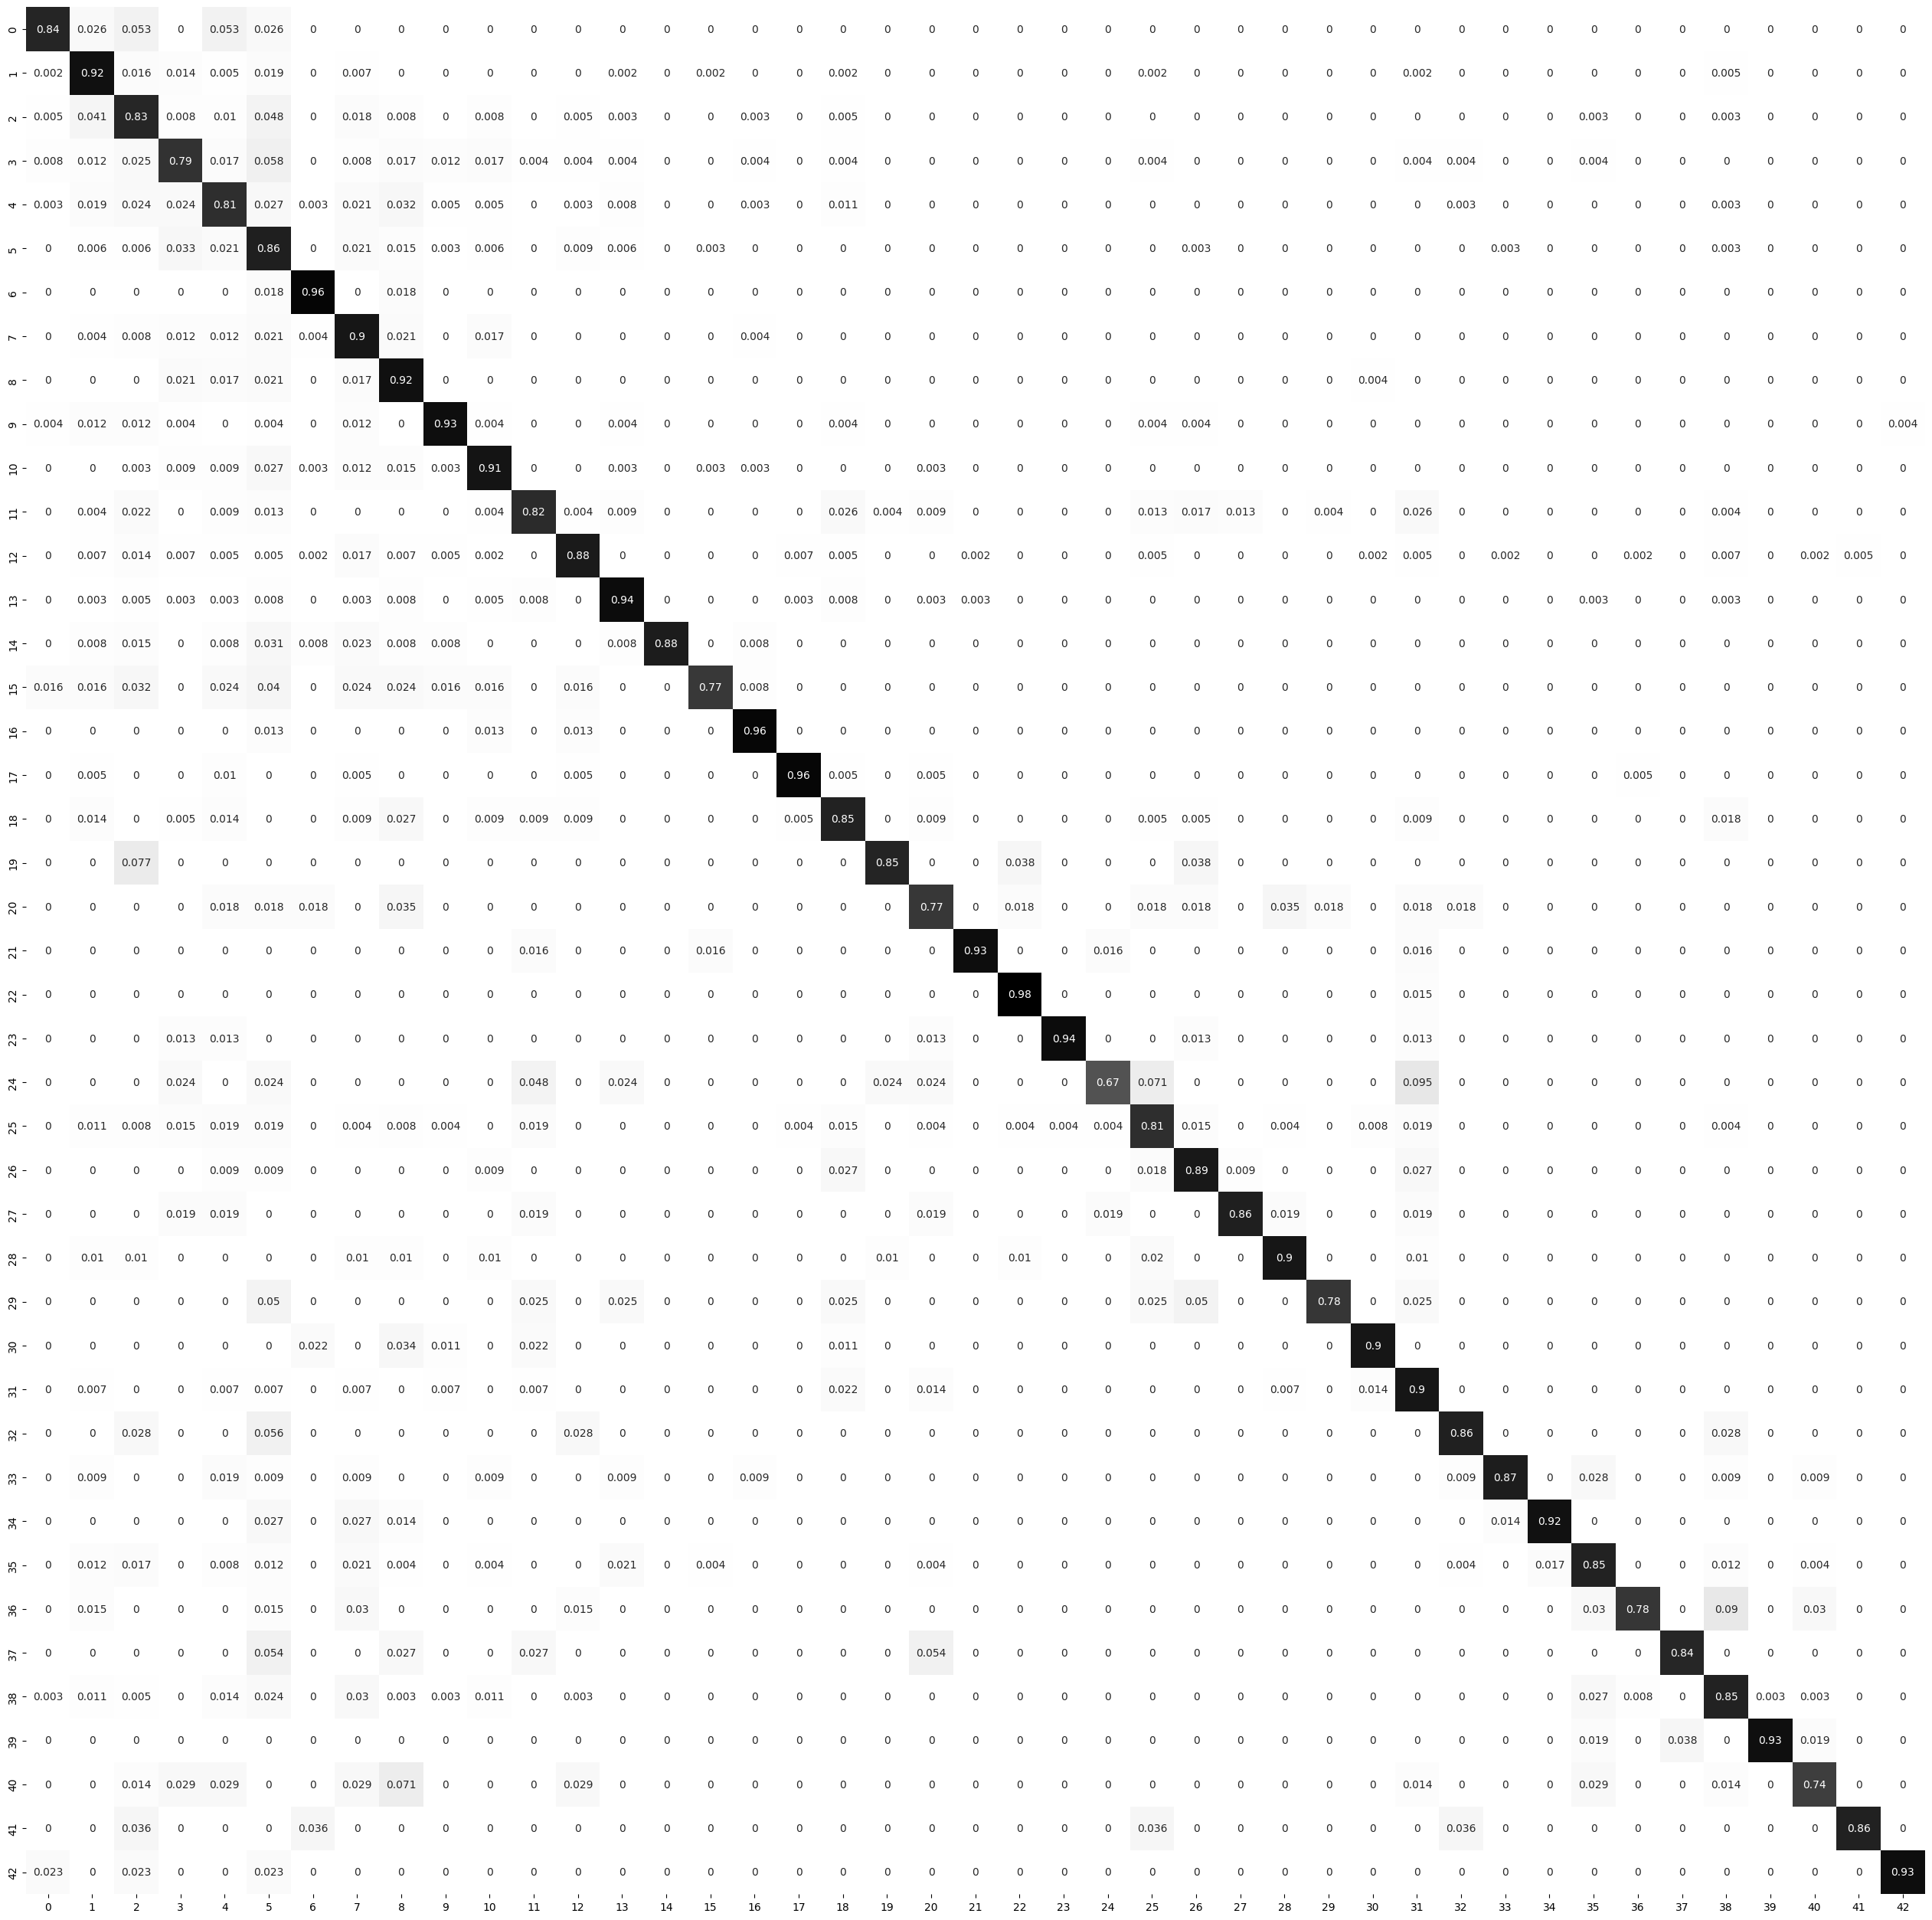

In [14]:
print_score(y_test, y_pred_knn)

У KNN тоже неплохой скор, но хуже линейной регрессии

### Naive Bayes

In [15]:
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)

accuracy_score:		0.32729885057471264
precision_score:	0.4248911874993429
recall_score:		0.34906770358052397
f1_score:		0.3306574461544411


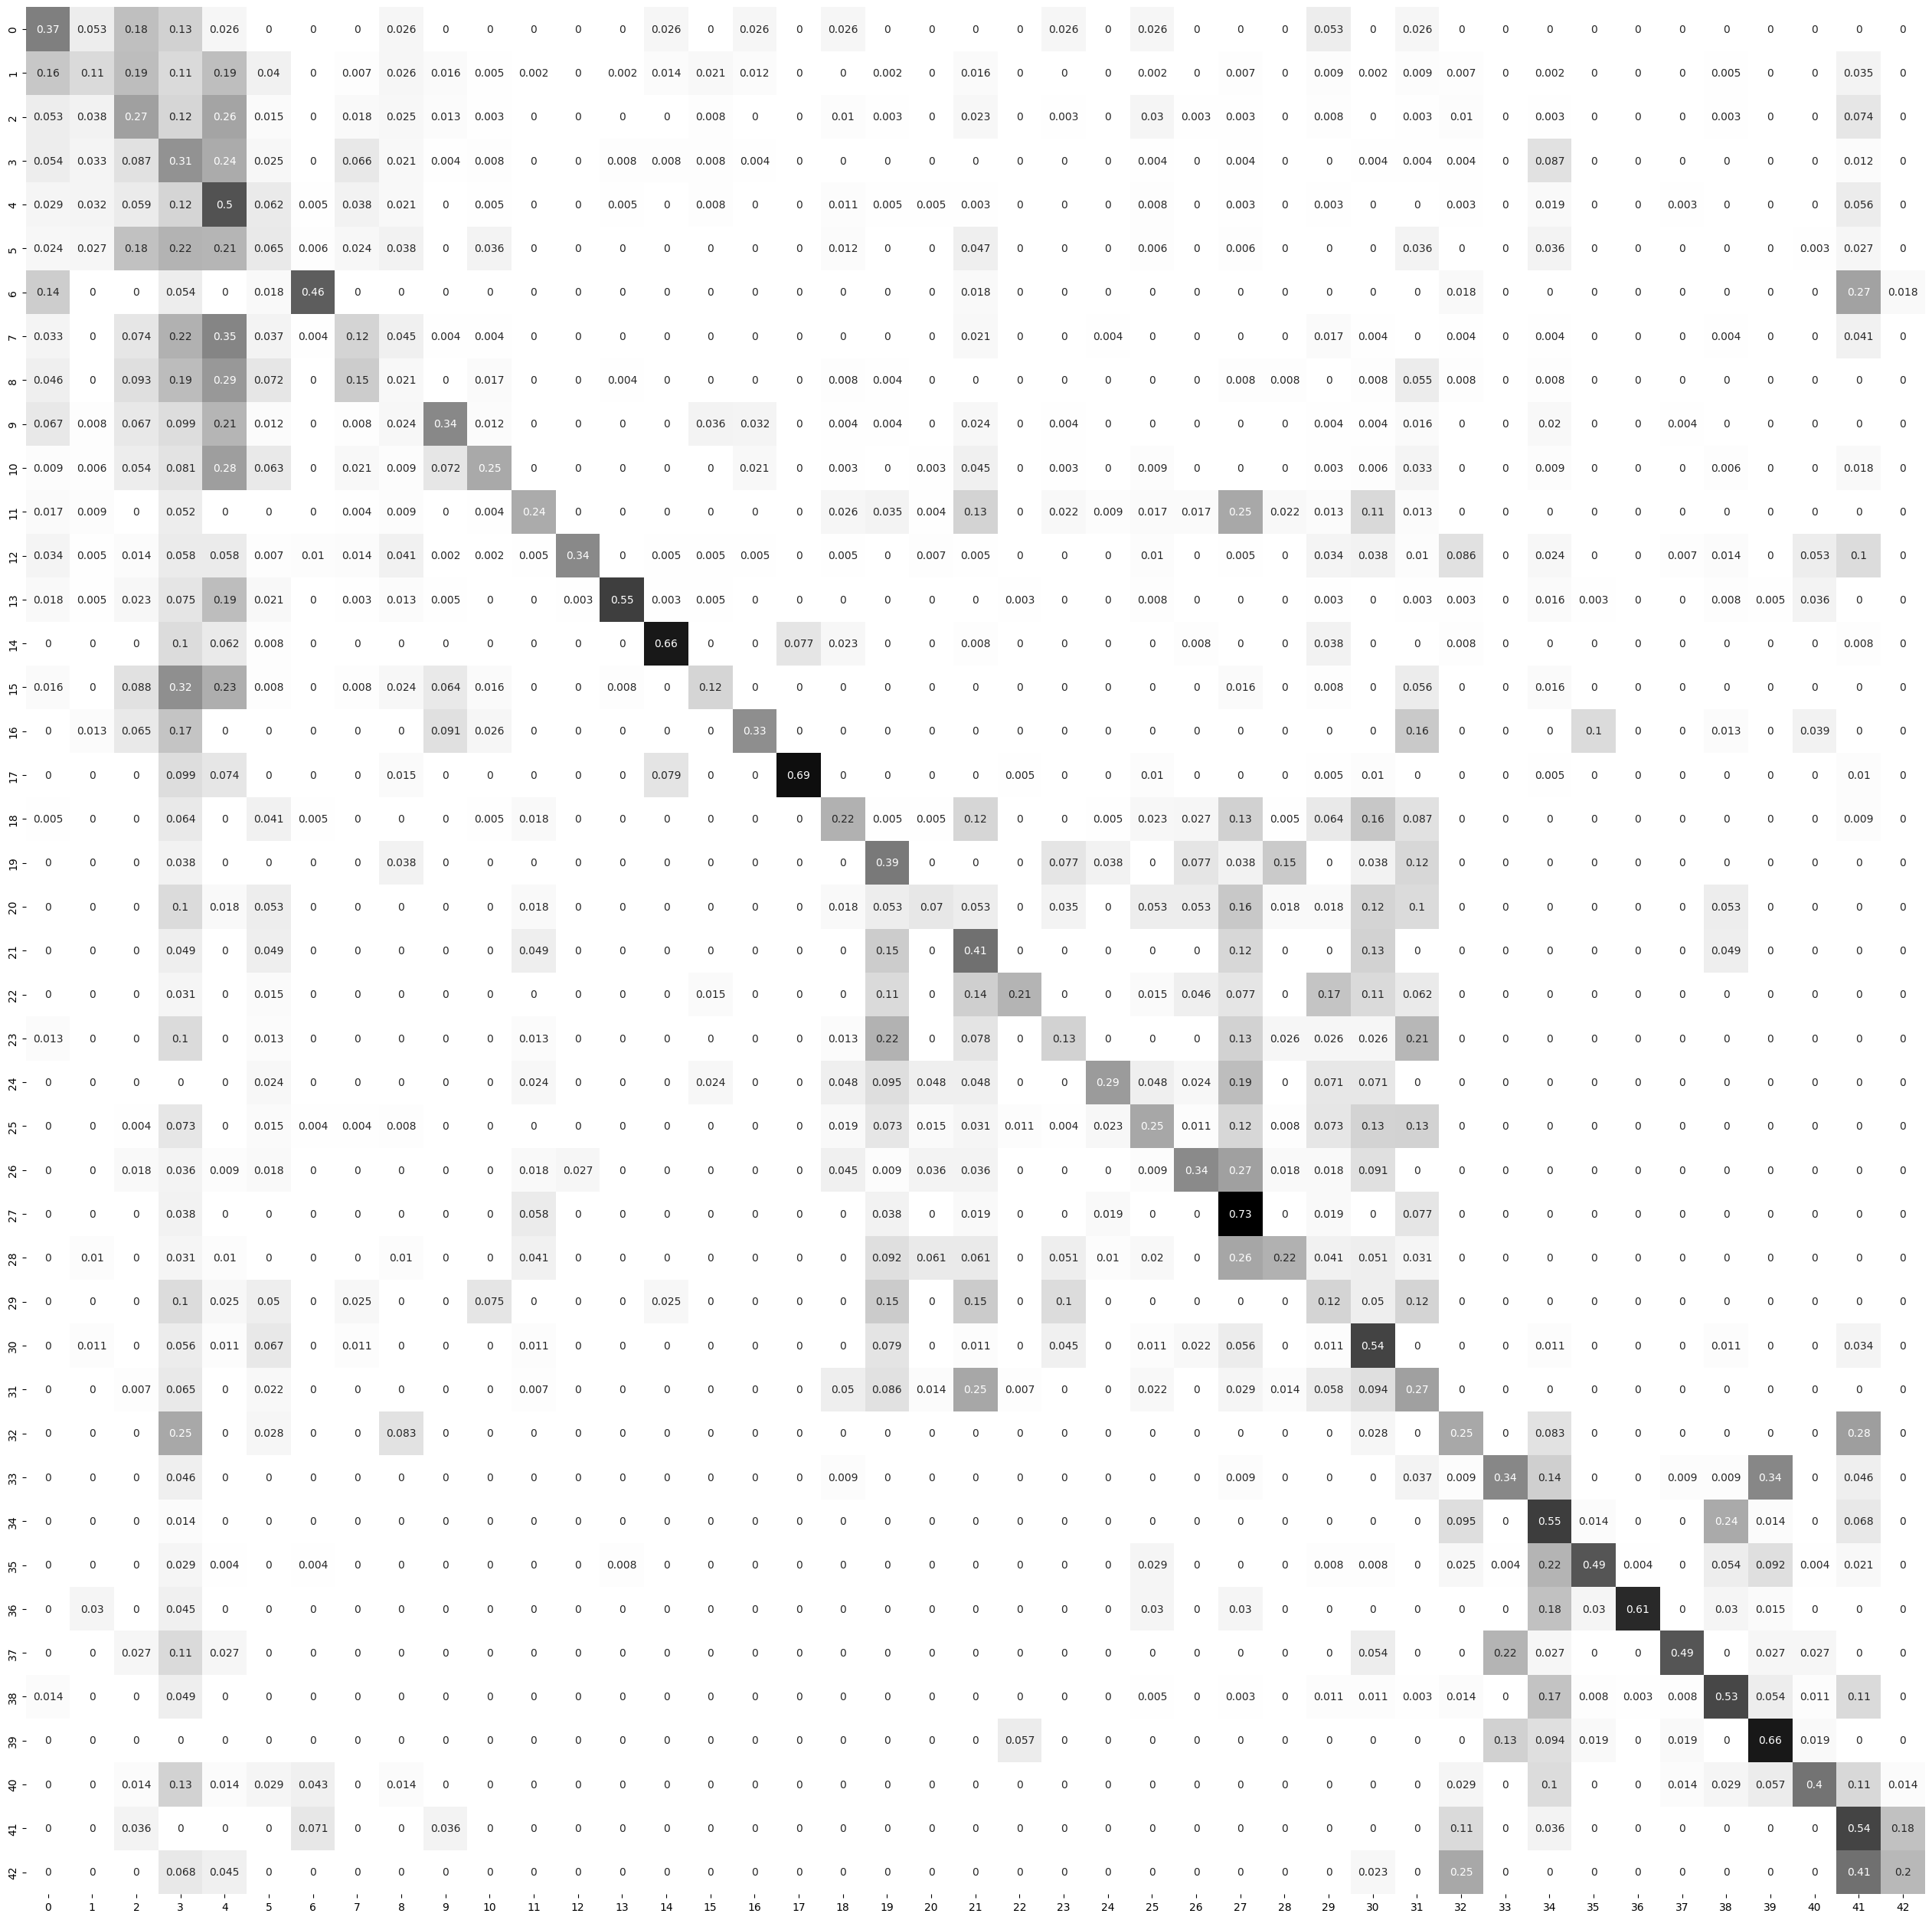

In [16]:
print_score(y_test, y_pred_nb)

У Байесовского классификатора самый плохой скор, но это логично - он подразумевает, что признаки независимы, а цвета пикселей явно зависят друг от друга

### SVC - linear kernel

In [17]:
model_scv_lin = SVC(kernel="linear", random_state=42)
model_scv_lin.fit(X_train, y_train)
y_pred_svc_lin = model_scv_lin.predict(X_test)

accuracy_score:		0.9583333333333334
precision_score:	0.9508781861300024
recall_score:		0.9589461192666224
f1_score:		0.9539920053757324


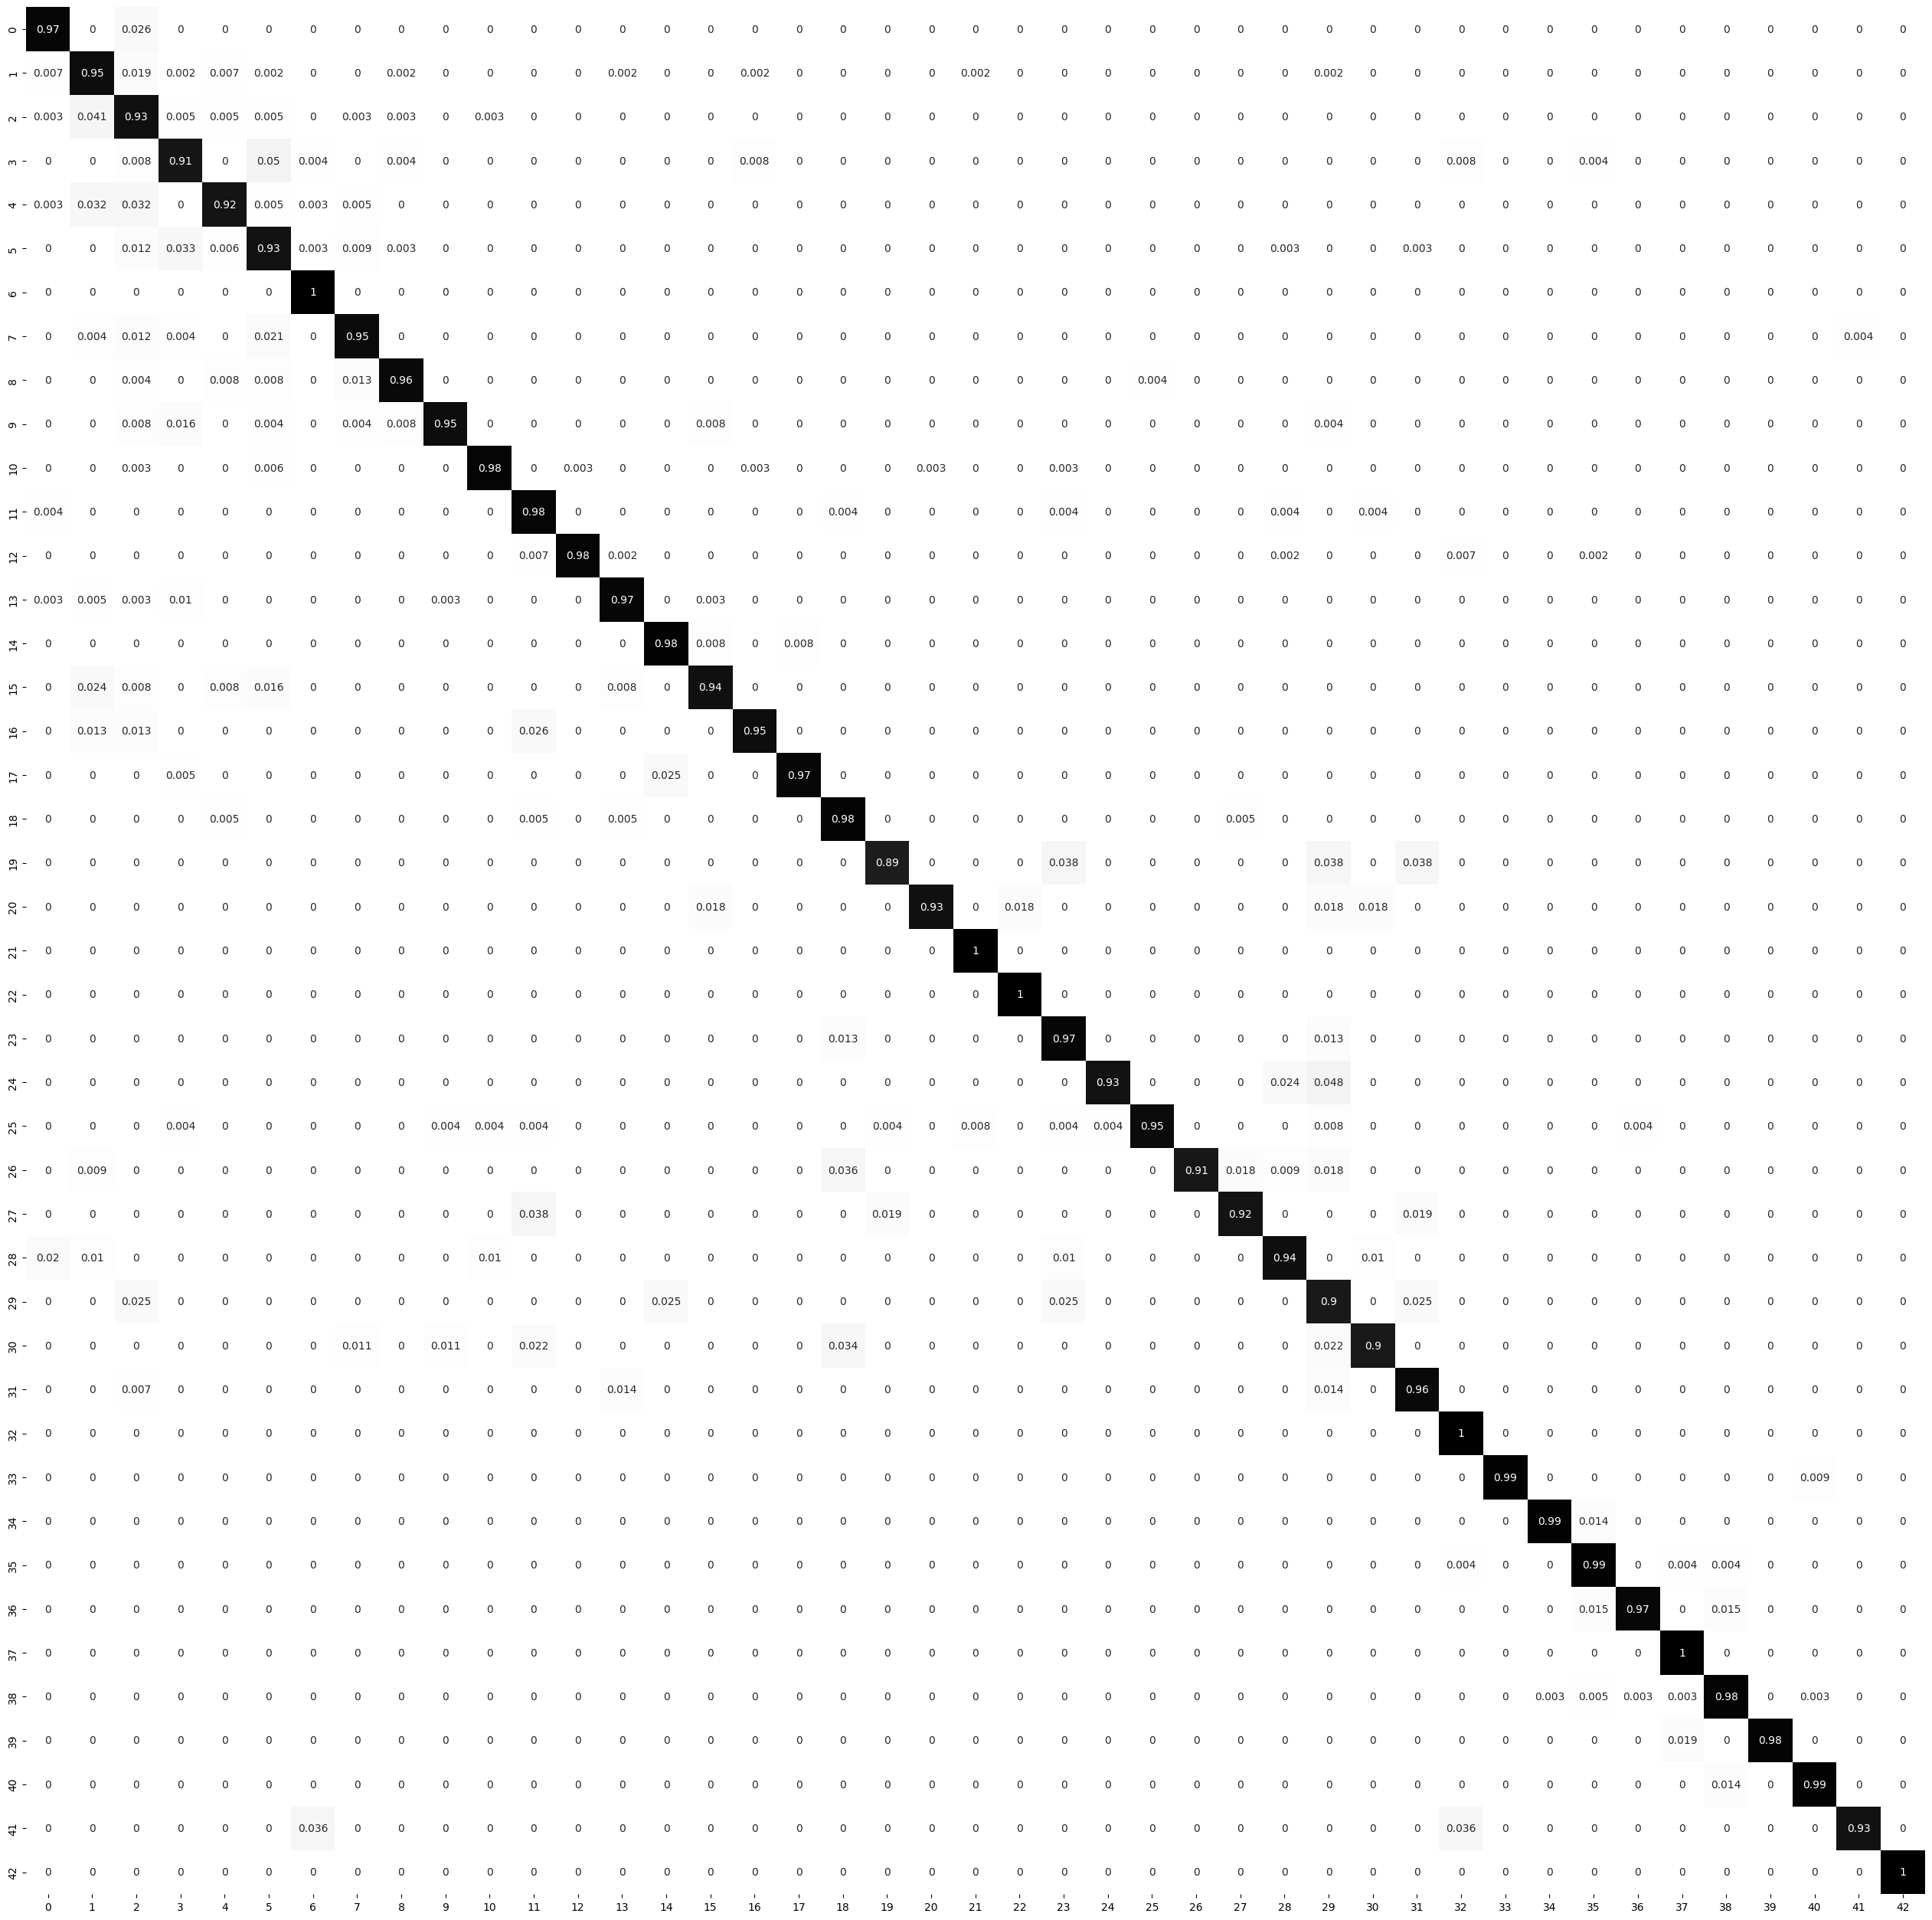

In [18]:
print_score(y_test, y_pred_svc_lin)

SVC с линейным ядром показал себя очень хорошо, лучше линейной регрессии, причем теперь нет явного аутсайдера в виде знака "Bicycles crossing"

### SVC - poly kernel

In [19]:
model_scv_ploy = SVC(kernel="poly", random_state=42)
model_scv_ploy.fit(X_train, y_train)
y_pred_scv_ploy = model_scv_ploy.predict(X_test)

accuracy_score:		0.7163793103448276
precision_score:	0.8693818842885899
recall_score:		0.6915173913223723
f1_score:		0.7426834781063428


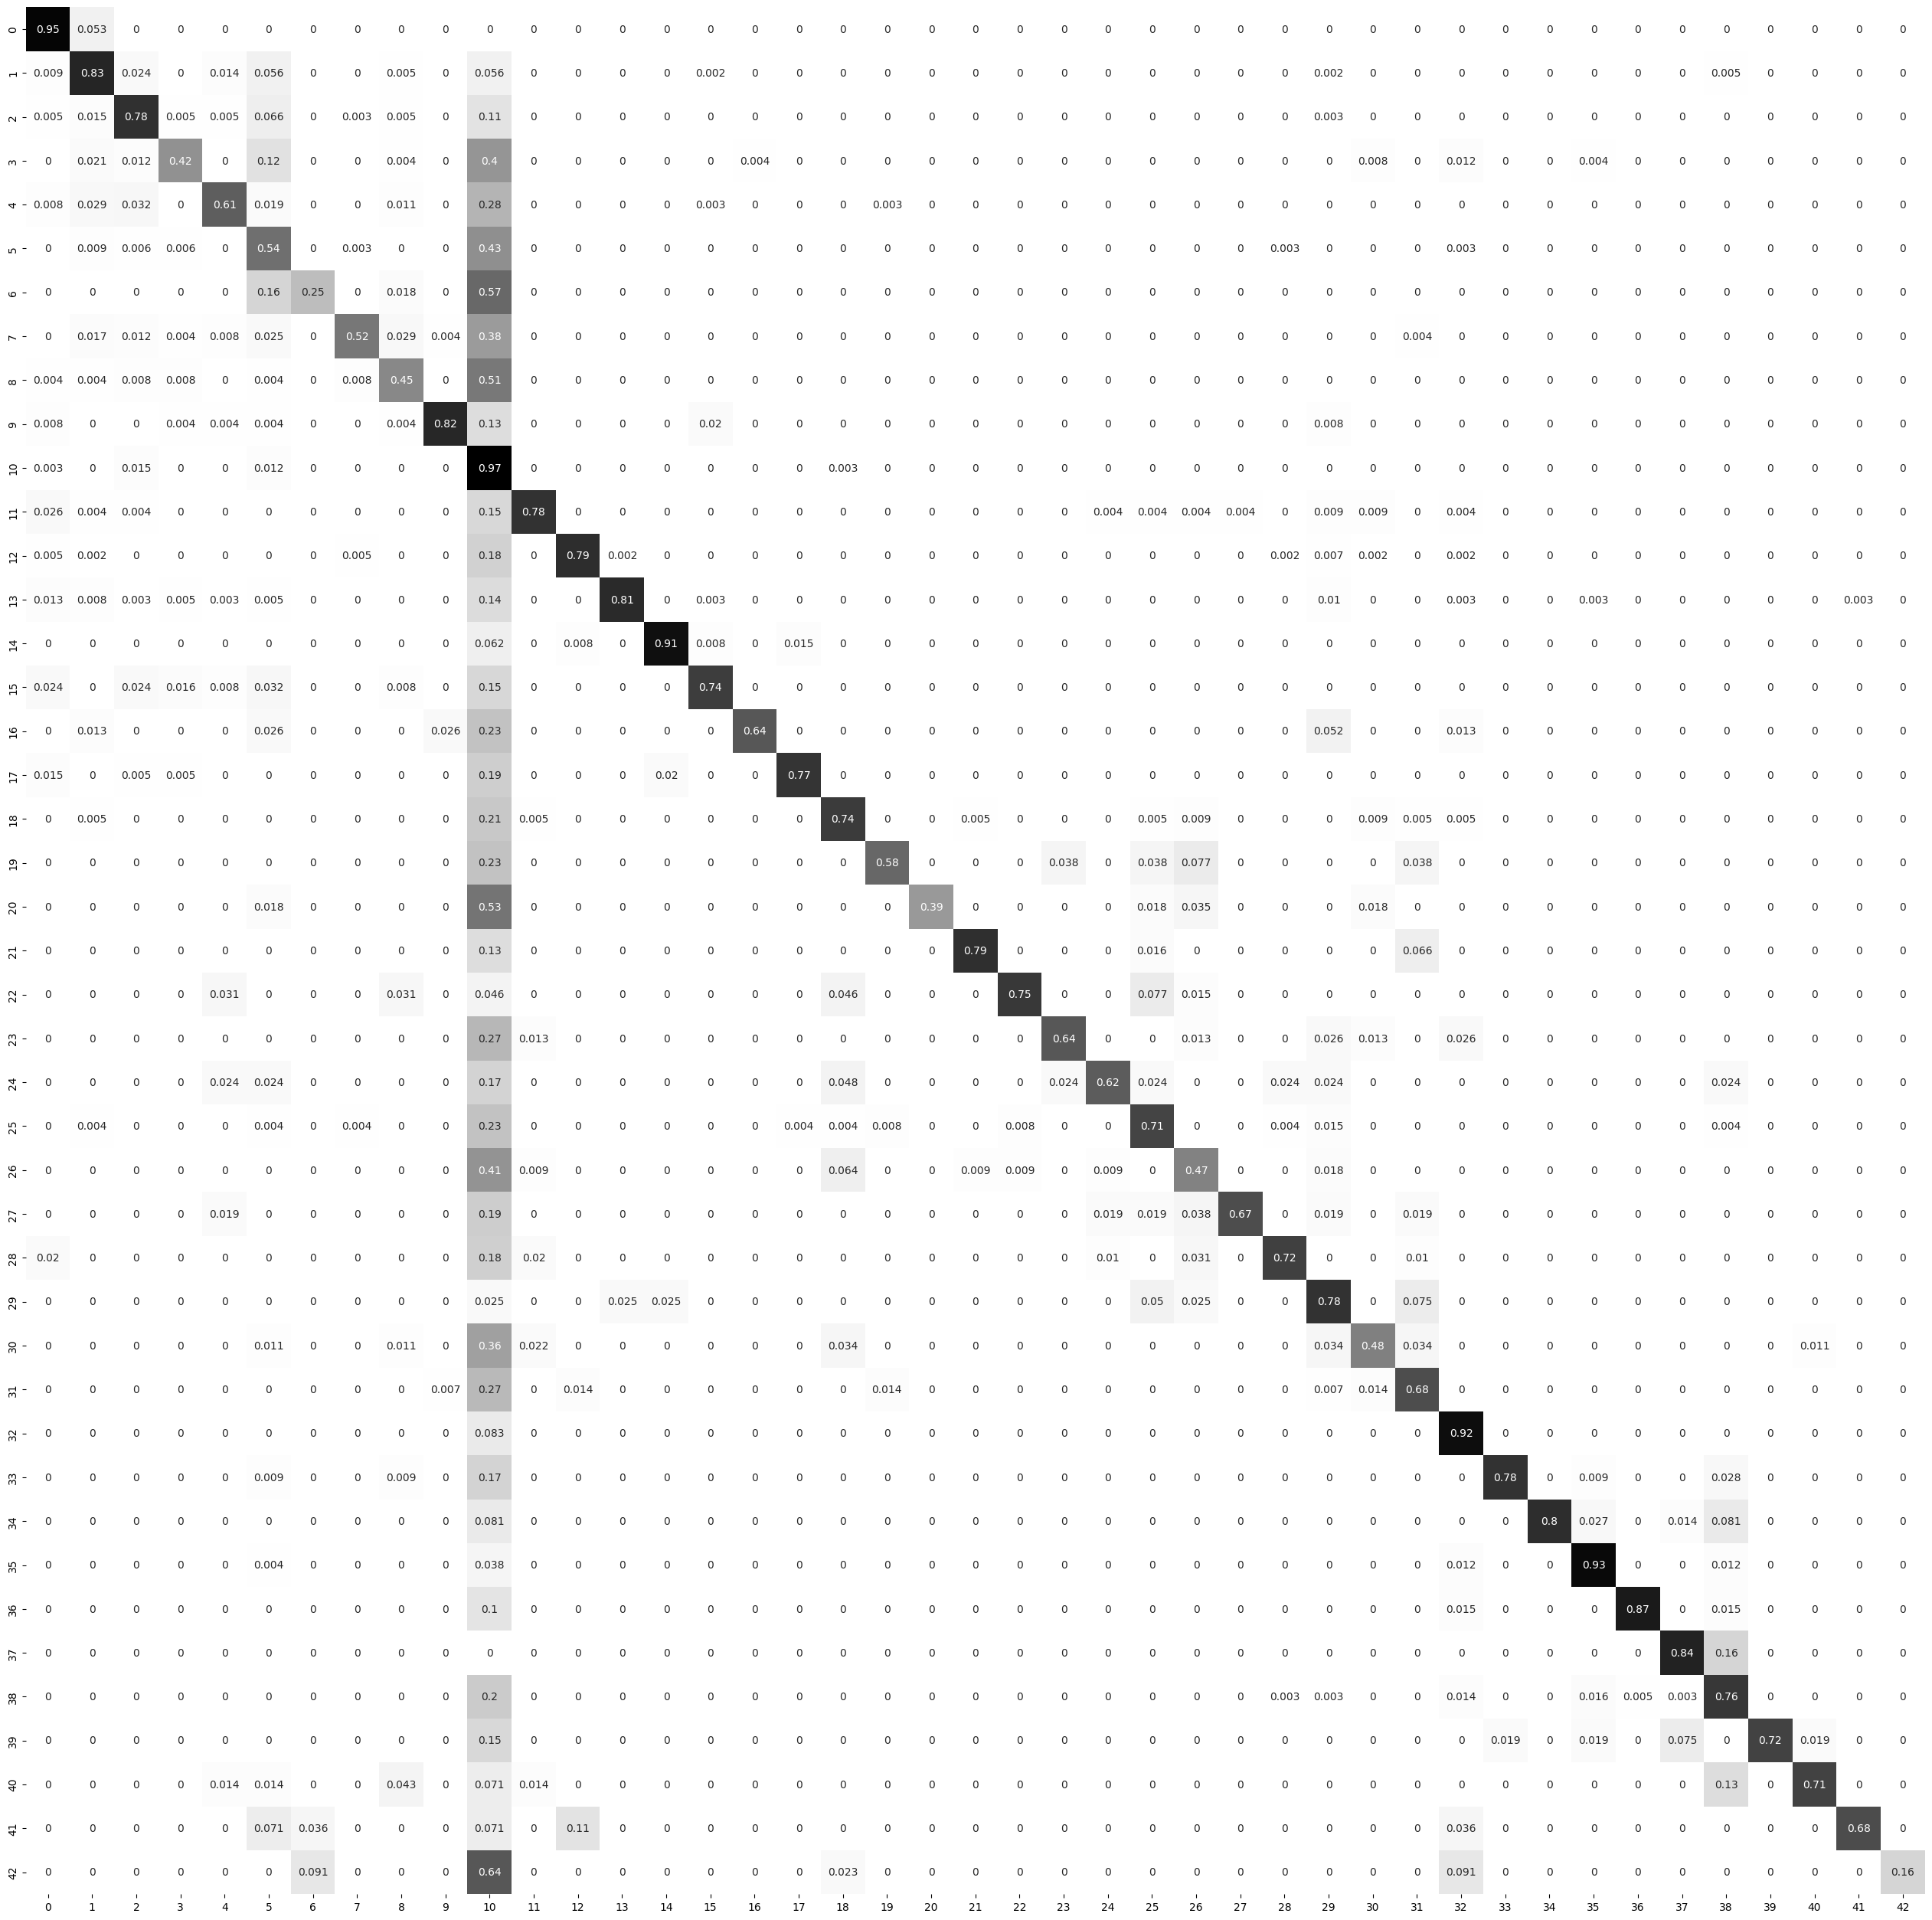

In [20]:
print_score(y_test, y_pred_scv_ploy)

SVC с полиномиальным ядром внезапно показал себя не очень хорошо

### SVC - rbf kernel

In [21]:
model_svc_rbf = SVC(kernel="rbf", random_state=42)
model_svc_rbf.fit(X_train, y_train)
y_pred_svc_rbf = model_svc_rbf.predict(X_test)

accuracy_score:		0.8810344827586207
precision_score:	0.9293951757758994
recall_score:		0.843371928963705
f1_score:		0.8774104702188291


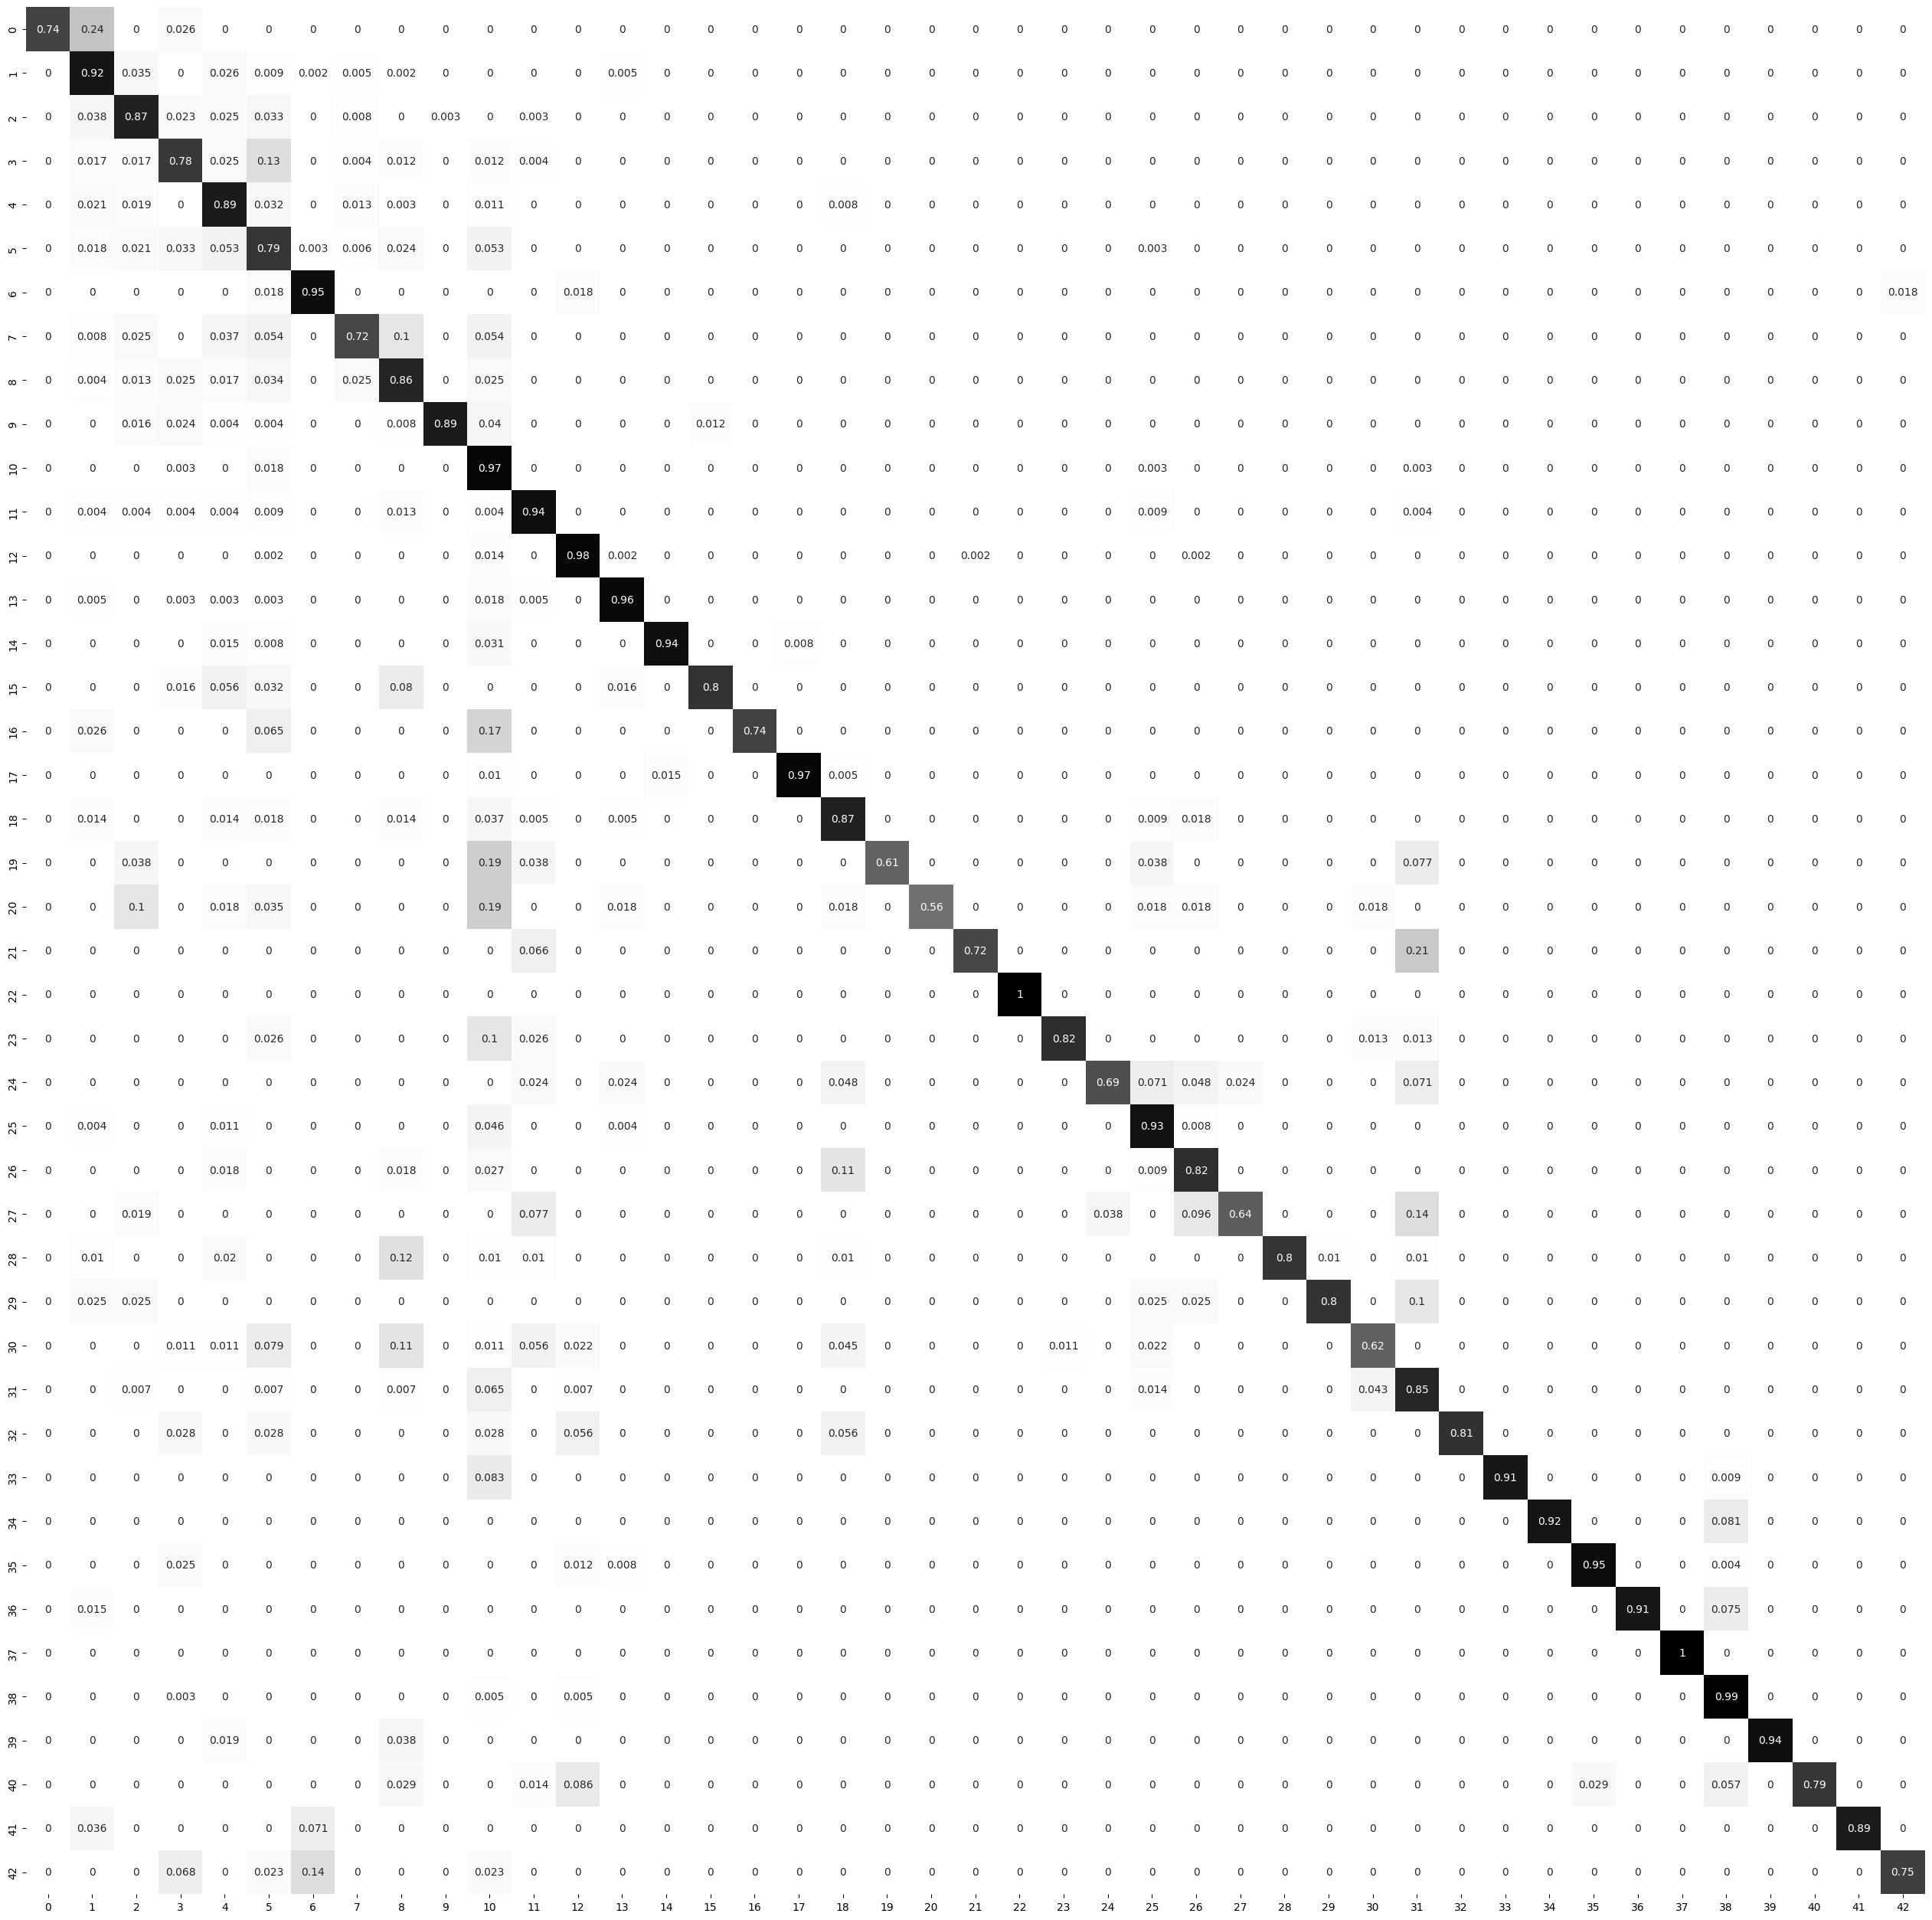

In [22]:
print_score(y_test, y_pred_svc_rbf)

SVC с rbf ядром показал себя лучше полиномиального, но хуже линейного